In [1]:
from modules.building_data import get_tile, osmbuildings_request, receive_building_data, polyarea, get_tile, tile_bbox

In [2]:
from modules.building_data import get_all_tiles, get_all_tile_jsons, get_tiles, get_split_coords

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp
import requests
import pandas as pd
import warnings
from shapely.geometry import Polygon
from modules.polygon_intersections import PolygonClipper
from ast import literal_eval

In [5]:
paris_df = pd.read_csv("../data/processed_data/Paris/Paris.csv")

In [6]:
paris_df.head()

,LST,ele,LST_diff,ele_diff,ul_corner,ll_corner,lr_corner,ur_corner,bb
0,28.489990,45.577310,-2.315979,-28.184334,"[[2.2633263464873545, 48.81321032181281]]","[[2.2633263464873545, 48.813839888049166]]","[[2.2639559127237074, 48.813839888049166]]","[[2.2639559127237074, 48.81321032181281]]","[[2.2633263464873545, 48.81321032181281], [2.2..."
1,28.549988,45.577430,-2.255981,-28.184212,"[[2.2639559127237074, 48.81321032181281]]","[[2.2639559127237074, 48.813839888049166]]","[[2.2645854789600603, 48.813839888049166]]","[[2.2645854789600603, 48.81321032181281]]","[[2.2639559127237074, 48.81321032181281], [2.2..."
2,28.450012,46.947140,-2.355957,-26.814503,"[[2.2645854789600603, 48.81321032181281]]","[[2.2645854789600603, 48.813839888049166]]","[[2.2652150451964133, 48.813839888049166]]","[[2.2652150451964133, 48.81321032181281]]","[[2.2645854789600603, 48.81321032181281], [2.2..."
3,29.230011,48.411680,-1.575958,-25.349964,"[[2.2652150451964133, 48.81321032181281]]","[[2.2652150451964133, 48.813839888049166]]","[[2.265844611432766, 48.813839888049166]]","[[2.265844611432766, 48.81321032181281]]","[[2.2652150451964133, 48.81321032181281], [2.2..."
4,27.889984,48.643574,-2.915985,-25.118069,"[[2.265844611432766, 48.81321032181281]]","[[2.265844611432766, 48.813839888049166]]","[[2.266474177669119, 48.813839888049166]]","[[2.266474177669119, 48.81321032181281]]","[[2.265844611432766, 48.81321032181281], [2.26..."


In [8]:
paris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35028 entries, 0 to 35027
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LST        35028 non-null  float64
 1   ele        35028 non-null  float64
 2   LST_diff   35028 non-null  float64
 3   ele_diff   35028 non-null  float64
 4   ul_corner  35028 non-null  object 
 5   ll_corner  35028 non-null  object 
 6   lr_corner  35028 non-null  object 
 7   ur_corner  35028 non-null  object 
 8   bb         35028 non-null  object 
dtypes: float64(4), object(5)
memory usage: 2.4+ MB


In [9]:
paris_df['test'] = paris_df['bb'].copy()

In [10]:
paris_df['test'] = paris_df.test.apply(literal_eval)

In [11]:
type(paris_df.test[0])

list

In [ ]:
# paris_df.bb.apply(lambda x: x.)

In [ ]:
# paris_df['test'] = paris_df['test'].replace('[]', '')

In [ ]:
# paris_df.bb.apply(lambda x: x.)

In [12]:
clip = PolygonClipper(warn_if_empty=False)

In [13]:
def get_building_clipped_area(building_coords, clip, pixel):
    clipped = clip(pixel, building_coords)
    pgon = Polygon(clipped)
    return pgon.area

In [15]:
def is_building_inside(building_coords, pixel):
    inside=True
    for coord in building_coords:
        if pixel[0][0] < coord[0] < pixel[2][0] and pixel[0][1] < coord[1] < pixel[1][1]:
            pass
        else:
            inside = False
    return inside

In [16]:
def get_building_coverage(buildings, clip, pixel):
    separate_areas = []
    for building in buildings:
        building_coords = building[1]
        try:
            separate_areas.append(get_building_clipped_area(building, clip, pixel))
        except:
            if is_building_inside(building_coords, pixel):
                pgon = Polygon(building_coords)
                separate_areas.append(pgon.area)
    built_area = np.sum(separate_areas)
    pixel_returning = pixel.copy()
    pixel_returning.append(pixel[0])
    pixel_poly = Polygon(pixel_returning)
    pixel_area = pixel_poly.area
    prop_area_built = built_area/pixel_area
    return prop_area_built

In [17]:
paris_coords = {'upper_left': [48.813898, 2.264216],
                'lower_right': [48.900502, 2.42172]}

In [18]:
paris_tiles = get_tiles(paris_coords)
paris_x_tiles, paris_y_tiles = get_all_tiles(paris_coords, paris_tiles)
paris_jsons = get_all_tile_jsons(paris_x_tiles, paris_y_tiles)
paris_buildings = receive_building_data(paris_jsons)

URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16590/11279.json
URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16590/11280.json
URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16590/11281.json
URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16590/11282.json
URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16590/11283.json
URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16590/11284.json
URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16590/11285.json
URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16590/11286.json
URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16590/11287.json
URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16590/11288.json
URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16590/11289.json
URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16591/11279.json
URL: https://data.osmbuildings.org/0.2/anonymous/tile/15/16591/11280.json
URL: https://data.osmbuildings.org/0.2

ConnectionError: HTTPSConnectionPool(host='data.osmbuildings.org', port=443): Max retries exceeded with url: /0.2/anonymous/tile/15/16594/11285.json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f23c549b9a0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

In [20]:
paris_jsons[0]

NameError: name 'paris_jsons' is not defined

In [16]:
single_pixel = paris_df['test'][0]

In [40]:
single_pixel

[[2.2633263464873545, 48.81321032181281],
 [2.2633263464873545, 48.813839888049166],
 [2.2639559127237074, 48.813839888049166],
 [2.2639559127237074, 48.81321032181281]]

In [87]:
building_density = get_building_coverage(paris_buildings, clip, single_pixel)

In [88]:
building_density

0.027406419466892006

In [32]:
test_set = paris_df['test'][:10]

In [89]:
building_densities = [get_building_coverage(paris_buildings, clip, pixel) for pixel in test_set]

In [90]:
building_densities

[0.027406419466892006,
 0.09271208456622948,
 0.06005162768672451,
 0.004278246729816333,
 0.01312244811213052,
 0.017363859450119708,
 0.03459807158376528,
 0.010080973420051632,
 0.047053275099517414,
 0.05453027720990245]

In [ ]:
[0.027406419466892006,
 0.00861925398265395,
 0.06005162768672451,
 0.004278246729816333,
 0.01312244811213052,
 0.017363859450119708,
 0.03459807158376528,
 0.010080973420051632,
 0.047053275099517414,
 0.05453027720990245]

In [39]:
# paris_df['building_density'] = paris_df.test.apply(lambda x : get_building_coverage(paris_buildings, clip, x))

In [47]:
type(paris_buildings[0][1][0][0])

float

In [46]:
type(single_pixel[0][0])

float

In [52]:
def get_matching_buildings(buildings, pixel):
    local_buildings = []
    for building in buildings:
        coords = building[1]
        for point in coords:
            if pixel[0][0] < point[0] < pixel[2][0] and pixel[0][1] < point[1] < pixel[1][1]:
                local_buildings.append(building)
                continue
    return local_buildings

In [53]:
matching_buildings = get_matching_buildings(paris_buildings, single_pixel)

In [59]:
def split_x_y(coords):
    x = []
    y = []
    for coord in coords:
        x.append(coord[0])
        y.append(coord[1])
    return x, y

In [101]:
def plot_buildings_pixel(buildings, pixel):
    pixel_returning = pixel.copy()
    pixel_returning.append(pixel[0])
    x, y = split_x_y(pixel_returning)
    plt.plot(x, y)
    for building in buildings:
        building_coords = building[1]
        x, y = split_x_y(building_coords)
        plt.plot(x, y)

In [61]:
troublesome_pixel = paris_df['test'][1]

In [62]:
matching_buildings2 = get_matching_buildings(paris_buildings, single_pixel)

In [72]:
x, y = split_x_y(single_pixel)
x2, y2 = split_x_y(troublesome_pixel)
print(x, y)

[2.2633263464873545, 2.2633263464873545, 2.2639559127237074, 2.2639559127237074] [48.81321032181281, 48.813839888049166, 48.813839888049166, 48.81321032181281]


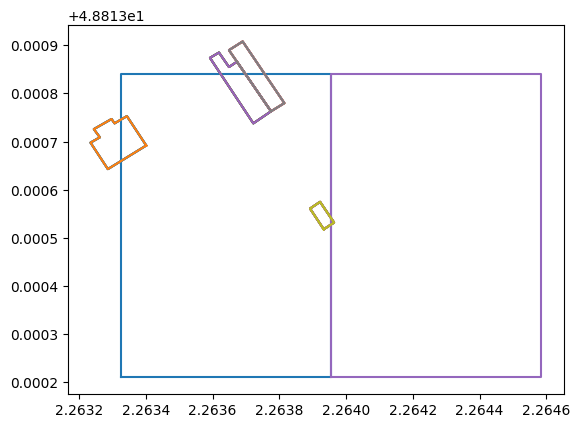

In [102]:
plot_buildings_pixel(matching_buildings, single_pixel)
plot_buildings_pixel(matching_buildings2, troublesome_pixel)

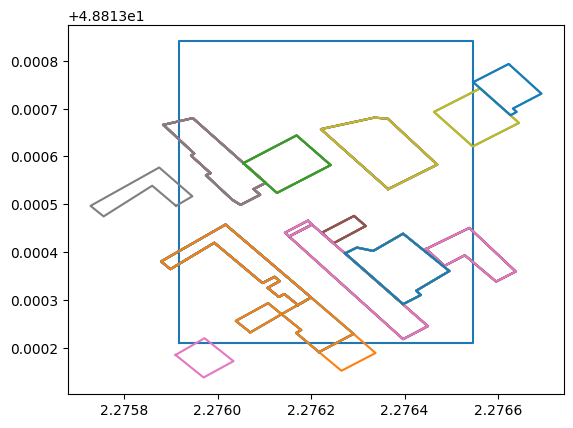

In [103]:
test_pixel = paris_df['test'][20]
matching_buildings3 = get_matching_buildings(paris_buildings, test_pixel)
plot_buildings_pixel(matching_buildings3, test_pixel)
building_density = get_building_coverage(paris_buildings, clip, test_pixel)
plt.title(f"Building density of pixel is: {round(building_density, 3)}")
plt.show;


In [105]:
# paris_df['building_density'] = paris_df['test'].apply(lambda x: get_building_coverage(paris_buildings, clip, x))